# Conversion of Raw lidar data to cloud and precipitation classification

## Abstract

This Notebook contains the post processing of the lidar data, including the spatial and temporal integration, the system calibration, background correction, SNR estimation, volume depolarization estimation, Cloud masking and hidrometeor clasification. Quick looks and some statistics are generated as well. Results are saved in netCDF format.

## Import libraries

Generic and own packages stored in "lib" are loaded to be used along the notebook. 

In [1]:
import sys, os
sys.path.append("lib") # adding "lib" path with own packages
from Sigma_mol import sigma_mol # reads the radio sounsing and compute extinction coefficient
from scipy.interpolate import interp1d # to interpolate modeled variables to lidar heights
from lidar_integrating_space_time import Lidar_space_time as lidar_integ #integrates lidar raw data in height and time
from lidar_integrating_space_time_std import Lidar_space_time2 as lidar_integ_std #maybe not used
from fft_denoising import fft_denoising #maybe not used
from klett import Klett81b #maybe not used
import numpy as np 
import pylab #plots
from DP_simp import DP_simp # Curve simplification
from running_mean import running_mean # runing mean
from time2epoch import time2epoch #maybe not used?
#from cloud_mask_v1 import cloud_mask
from netCDF4 import Dataset 
#from time import sleep
from scipy import stats
from scipy.optimize import curve_fit
from dplots import densplot # make 2D desity plots
from Comb_LidarMRR import Comb_LidarMRR3 as Comb_LidarMRR 
from cloud_mask_v2 import cloud_mask2
from sm_paramTOP import sm_paramTOP
import matplotlib
from copy import copy
from BG_corr import BG_corr
import time

## Load MRR and other parameters

Load MRR data during the period of study. It also configures the font format and color maps

In [2]:
#####Load MRR Data
path_MRR = "I:/PHD/Lidar/Inversion_V2/MRR_Data/"
Ze = np.loadtxt(path_MRR + "Ze_10min.txt")
times_MRR = np.loadtxt(path_MRR + "times.txt")
Height_MRR = np.loadtxt(path_MRR + "Height.txt")

Zem = np.ma.masked_where(Ze == -9999, Ze)

#####Load font format

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
        
pylab.rc('font', **font)      

#####Color Parameters
cmap = pylab.cm.jet
bounds = np.linspace(1,3,4)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
bounds2 = np.linspace(0,12,14)
norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap.N)

cmap2 = pylab.cm.get_cmap(cmap.name,8)

##### output Temporal RESolution
TRES = 10 #min. 

##### output Temporal resolution
VRES = 6 #bins, 1bin = 3.8m # try only 1,2,3,6 bins


In [6]:
mat

[array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([ 0.01335902,  0.03626019,  0.05916136,  0.08206253,  0.10496371,
         0.12786488,  0.15076605,  0.17366722,  0.19656839,  0.219469

## Temporal and vertical integration

In [4]:
##### Dates
#[ini, end]
year0 = [2017, 2017]
month0 = [9,12]
day0 = [1,31]
t0 = time.time()
##### Routine
for year in range(year0[0],year0[1]+1):
    for month in range(month0[0],month0[1]+1):
        for day in range(day0[0],day0[1]+1):
    
            path_out = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
            filename1 = path_out+"Par90/Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename2 = path_out+"Par10/Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename3 = path_out+"Per/Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            
            filename4 = path_out+"Nprofiles/Nprofiles_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min"+".dat"
            
            if os.path.isfile(filename1):
                #Par90 = np.loadtxt(filename1)
                #Par10 = np.loadtxt(filename2)
                #Per   = np.loadtxt(filename3)
                #r   = np.loadtxt(path_out+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
                #npt = np.loadtxt(filename4)
                print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data loaded"

            else:
                #mat = lidar_integ(date = str(year)+"."+str(month).zfill(2)+"."+str(day).zfill(2), space = VRES, timee = TRES, 
                #              path = "K:/IGE/hmcis/APRES3-TASK2/DONNEES-LIDAR-ANTARCTIQUE/2017/")
                try:
                    mat = Lidar_space_time(date = str(year)+"."+str(month).zfill(2)+"."+str(day).zfill(2), space = VRES, timee = TRES, 
                              path = "G:/PC_chantal_20190131/MCS6A Data/")
                except:
                    continue
                    #print "what"
                print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data loaded"
                #sleep(8)
                np.savetxt(filename1,mat[0])
                np.savetxt(filename2,mat[1])
                np.savetxt(filename3,mat[2])
                #np.savetxt(path_out+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat",mat[3])
                np.savetxt(filename4,mat[4])
                #Par90 = mat[0]
                #Par10 = mat[1]
                #Per = mat[2]
                #npt = mat[4]
print "Elapsed time = ", (time.time() - t0)

20170701 Data loaded
20170702 Data loaded
20170703 Data loaded
20170704 Data loaded
20170705 Data loaded
20170706 Data loaded
20170707 Data loaded
20170708 Data loaded
20170709 Data loaded
20170710 Data loaded
20170711 Data loaded
20170712 Data loaded
20170713 Data loaded
20170714 Data loaded
20170715 Data loaded
20170716 Data loaded
20170717 Data loaded
20170718 Data loaded
20170719 Data loaded
20170720 Data loaded
20170721 Data loaded
20170722 Data loaded
20170723 Data loaded
20170724 Data loaded
20170725 Data loaded
20170726 Data loaded
20170727 Data loaded
20170728 Data loaded
20170729 Data loaded
20170730 Data loaded
20170731 Data loaded
20170801 Data loaded
20170802 Data loaded
20170803 Data loaded
20170804 Data loaded
20170805 Data loaded
20170806 Data loaded
20170807 Data loaded
20170808 Data loaded
20170809 Data loaded
20170810 Data loaded
20170811 Data loaded
20170812 Data loaded
20170813 Data loaded
20170814 Data loaded
20170815 Data loaded
20170816 Data loaded
20170817 Data

## Background correction and SNR

In [102]:
for count in range(1):
    if count > 0: print "Next iteration"
    ##### Dates
    #[ini, end]
    year0 = [2017,2017]
    month0 = [2,12]
    day0 = [1,31]

    ##### Routine
    for year in range(year0[0],year0[1]+1):
        for month in range(month0[0],month0[1]+1):
            for day in range(day0[0],day0[1]+1):

                path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
                filename1 = path_in+"Par90/Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename2 = path_in+"Par10/Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename3 = path_in+"Per/Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename4 = path_in+"Nprofiles/Nprofiles_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min"+".dat"

                path_out = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
                filename5 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename6 = path_in+"Par10_bc/Par10bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename7 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

                filename8 = path_in+"SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename9 = path_in+"SNR/SNR_Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename10 = path_in+"SNR/SNR_Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

                filename11 = path_in+"Background/BG_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename12 = path_in+"Background/BG_Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename13 = path_in+"Background/BG_Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                
                if os.path.isfile(filename13):
                    #print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data ready"
                    continue
                
                if os.path.isfile(filename1):
                    Par90 = np.loadtxt(filename1)
                    Par10 = np.loadtxt(filename2)
                    Per   = np.loadtxt(filename3)
                    r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
                    npt = np.loadtxt(filename4)

                    BG1 = np.zeros(shape = np.shape(Par90)[0])
                    BG10 = np.zeros(shape = np.shape(Par90)[0])
                    BG2 = np.zeros(shape = np.shape(Par90)[0])

                    print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data loaded"
                else:
                    #print "File not found"
                    continue

                Par_bc = np.zeros(shape = np.shape(Par90))
                Par10_bc = np.zeros(shape = np.shape(Par90))
                Per_bc = np.zeros(shape = np.shape(Per))
                SNR_par = np.zeros(shape = np.shape(Per))
                SNR_par10 = np.zeros(shape = np.shape(Per))
                SNR_per = np.zeros(shape = np.shape(Per))

                for i in range(np.shape(Par90)[0]):
                    try:
                        BG1[i] = BG_corr(Par90[i,:],r[:],year, month, day,rcf0 = 9,pol = 'parallel')[0][1]
                        BG10[i] = BG_corr(Par10[i,:],r[:],year, month, day,rcf0 = 9,pol = 'parallel')[0][1]
                        BG2[i] = BG_corr(Per[i,:],r[:],year, month, day,rcf0 = 9,pol = 'perpendicular')[0][1]  
                    except:
                        continue
                        
                    if BG1[i] < 0: BG1[i] = 0
                    if BG10[i] < 0: BG10[i] = 0
                    if BG2[i] < 0: BG2[i] = 0

                    if BG1[i] > np.nanmean(Par90[i,-50:]): BG1[i] = np.nanmean(Par90[i,-50:])
                    if BG10[i] > np.nanmean(Par10[i,-50:]): BG10[i] = np.nanmean(Par10[i,-50:])
                    if BG2[i] > np.nanmean(Per[i,-50:]): BG2[i] = np.nanmean(Per[i,-50:])

                    Par_bc[i,:] = Par90[i,:]-BG1[i]
                    Par10_bc[i,:] = Par10[i,:]-BG10[i]
                    Per_bc[i,:] = Per[i,:]-BG2[i]  

                    SNR_par[i,:] = (Par_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Par_bc[i,:]+2*(BG1[i]))**0.5
                    SNR_par10[i,:] = (Par10_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Par10_bc[i,:]+2*(BG10[i]))**0.5
                    SNR_per[i,:] = (Per_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Per_bc[i,:]+2*(BG2[i]))**0.5

                    Par_bc[i,:] = (Par_bc[i,:])*r**2
                    Par10_bc[i,:] = (Par10_bc[i,:])*r**2
                    Per_bc[i,:] = (Per_bc[i,:])*r**2  

                np.savetxt(filename5,Par_bc)
                np.savetxt(filename6,Par10_bc)
                np.savetxt(filename7,Per_bc)

                np.savetxt(filename8,SNR_par)
                np.savetxt(filename9,SNR_par10)
                np.savetxt(filename10,SNR_per)

                np.savetxt(filename11,BG1)
                np.savetxt(filename12,BG10)
                np.savetxt(filename13,BG2)
    #print "waiting 15 minutes..."
    #time.sleep(15*60)
    #print "iteration = ", count
    

## Calibration system 

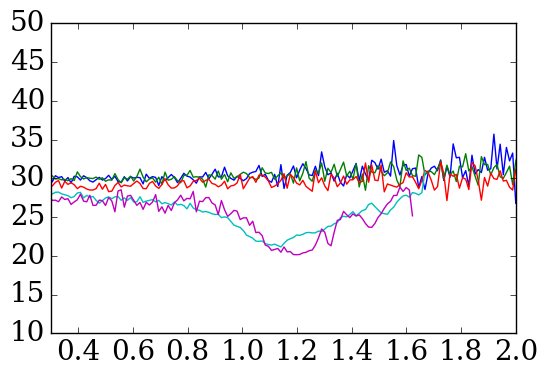

In [154]:
#pylab.plot(r,Par_bc[12*1,:]/Par10_bc[12*1,:])
#pylab.plot(r,Par_bc[12*2,:]/Par10_bc[12*2,:])
#pylab.plot(r,Par_bc[12*3,:]/Par10_bc[12*3,:])
#pylab.plot(r,Par_bc[12*4,:]/Par10_bc[12*4,:])
#pylab.plot(r,Par_bc[12*5,:]/Par10_bc[12*5,:])
#pylab.plot(r,Par_bc[12*8,:]/Par10_bc[12*8,:])
pylab.plot(r,Par_bc[12*10,:]/Par10_bc[12*10,:])
pylab.plot(r,Par_bc[12*12,:]/Par10_bc[12*12,:])
pylab.plot(r,Par_bc[12*14,:]/Par10_bc[12*14,:])
pylab.plot(r,Par_bc[12*20,:]/Par10_bc[12*20,:])
pylab.plot(r,Par_bc[12*22,:]/Par10_bc[12*22,:])
#pylab.plot(r,Par10_bc[12*12,:])
#pylab.yscale("log")
pylab.axis([0.3,2,10,50])
pylab.show()

In [ ]:
from random import radom

In [2]:

pylab.plot(r,(Par90)[12*12,:]/(Par10)[12*12,:])
pylab.plot(r,(Par90)[12*22,:]/(Par10)[12*22,:])
pylab.axis([0.5,10,0,100])
pylab.show()


#P(x)90 = CbT/r2+Bs90 - sat(r)
#P(x)90 = CbT/r2+Bs10

val1 = np.linspace(1,100,100)
val2 = val1*30.

pylab.plot(val2/val1)
pylab.show()

NameError: name 'pylab' is not defined

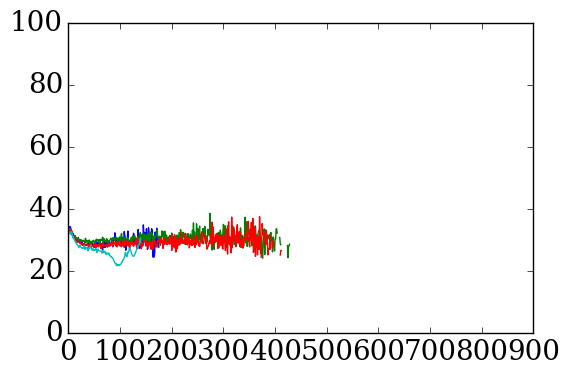

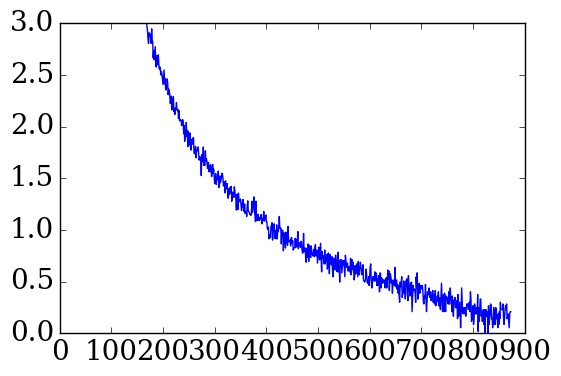

In [65]:
pylab.plot((Par_bc/Par10_bc)[100,:])
pylab.plot((Par_bc/Par10_bc)[150,:])
pylab.plot((Par_bc/Par10_bc)[200,:])
pylab.plot((Par_bc/Par10_bc)[250,:])
pylab.axis([0,900,0,100])
pylab.show()
pylab.plot(SNR_par10[150,:])
pylab.axis([0,900,0,3])
pylab.show()

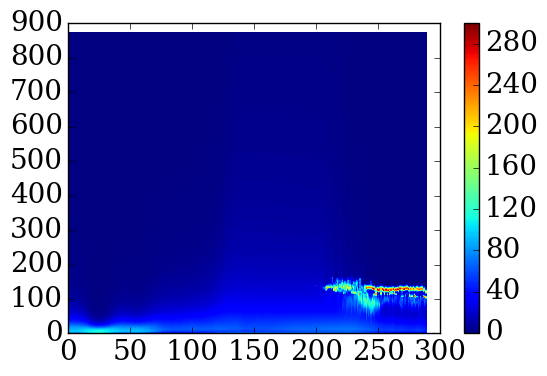

In [55]:
pylab.pcolor(np.transpose(SNR_par))
pylab.colorbar()
pylab.show()

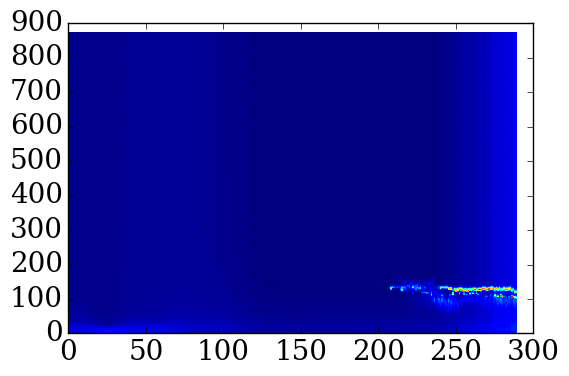

In [21]:
pylab.pcolor(np.transpose(mat[1]))
pylab.show()

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


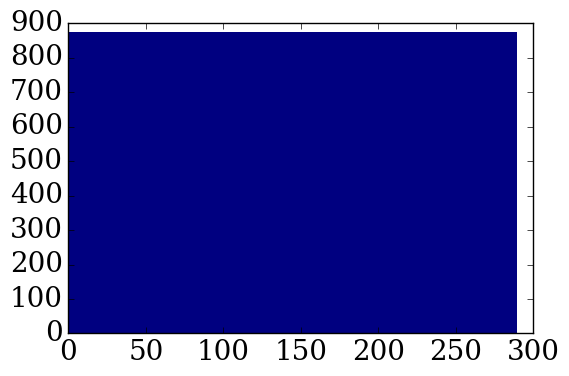

In [20]:
pylab.pcolor(np.transpose(SNR_per))
pylab.show()

In [5]:
mat = Lidar_space_time(date = str(year)+"."+str(month).zfill(2)+"."+str(day).zfill(2), space = VRES, timee = TRES, 
                       path = "K:/IGE/hmcis/APRES3-TASK2/DONNEES-LIDAR-ANTARCTIQUE/2017/")

Reading data...
(It can takes a few minutes)
2017.02.25file was readed.


In [29]:
np.max(mat[0])

103882.19540229884

In [3]:
import time, os, glob, pylab
from calendar import timegm
import numpy as np

t0=time.time() 

def Lidar_space_time(date = "2017.02.04",space = 13, timee = 60,path = "C:/Users/admduaan/Documents/PhD/DDU/DATA/LIDAR/"):

    #####################
    #To modify by the user
    #date = "2017.02.25" #Date YYYY.MM.DD
    #path = "C:/Users/lteadmin/Desktop/MCS6A Data/" #Check that the input path is OK
    #path = "I:/lidardata/MCS6A Data/"
    #path = "C:/Users/admduaan/Documents/PhD/DDU/DATA/LIDAR/"
    #path_out = "C:/temp/lidar/" # modified if you want to change the output directory
    tr = timee #60 # Temporal aggregation [minutes] you can try with 10, 30, 60min for example
    #####################
    
    #outputs: plots of lidar signal, dep. ratio and mean number of acquisitions per minute.  
        
    font = {'family'    :   'serif',
            'weight'    :   'normal',
            'size'      :   20}
    
    pylab.rc('font', **font)        
    
    def read_lidarfile(filename):
        import numpy as np
        f = open(filename,'r')
        data0 = np.array(f.readlines())
        f.close()    
        data_Size = np.size(data0)
      
        if (data_Size == 7883):      
            TDAT0 = np.array(data0[9:2633],dtype=float)#90% parallel
            TDAT1 = np.array(data0[2634:5258],dtype=float)#10% parallel
            TDAT2 = np.array(data0[5259:7883],dtype=float)#Perpendicular                
                           
            return [TDAT0[1:],TDAT1[1:],TDAT2[1:]]
    TZoff = 1 #Time Zone offset original data is in UTC+1 [h] do not change for DDU
    
    nt = 1440/tr+1 #number of steps
    
    mat_90par = np.zeros(shape=(nt,2623))
    mat_10par = np.zeros(shape=(nt,2623))
    mat_per = np.zeros(shape=(nt,2623))
    mat_npix= np.zeros(shape=(nt)) # number of profiles of each time steps, each profile is the sum of 10*7000 shoots
    
    year = date[0:4]
    month = date[5:7]
    day = date[8:10]
    
    #path=path+year+"/"
    
    utc_ti = time.strptime(year+"-"+month+"-"+day+"T00:00:00", "%Y-%m-%dT%H:%M:%S")
    ti = timegm(utc_ti)
    tf = ti + 3600*24
    
    times = np.linspace(ti,tf,nt)
    
    year2 = str(time.gmtime(ti+3600*24)[0])
    month2 = str(time.gmtime(ti+3600*24)[1]).zfill(2)
    day2 = str(time.gmtime(ti+3600*24)[2]).zfill(2)
    
    path1 = path+year+"."+month+"."+day+"/MCS6A data/"
    times1 = []
    path2 = path+year2+"."+month2+"."+day2+"/MCS6A data/"
    times2 = []
    
    print "Reading data..."
    print "(It can takes a few minutes)"
    
    if os.path.exists(path1):
        os.chdir(path1)
        filenames1 = glob.glob("*.txt")
        for txt in filenames1:
            times1.append(timegm(time.strptime(txt[0:4]+"-"+txt[4:6]+"-"+txt[6:8] + "T"+txt[9:11]+":"+txt[12:14]+":"+txt[15:17], "%Y-%m-%dT%H:%M:%S")))
        times1=np.array(times1)-TZoff*3600    
        filenames1=np.array(filenames1)
        t_count = 0
        for t in times:
            if t < min(times1)-60*tr:
                t_count = t_count + 1    
                continue
            if t > max(times1)+60*tr:
                break
            pix = np.where((times1 <= t) & (times1 > t-60*tr))  
            npix = 0. 
            if np.size(pix) > 0 : 
                par90sum =np.zeros(shape = (2623))
                par10sum =np.zeros(shape = (2623))
                persum =np.zeros(shape = (2623))
                try:
                    
                    for ppix in pix[0]:
                        filename = path1+filenames1[ppix]  
                        
                        par90,par10,per = read_lidarfile(filename)
                        par90sum = par90sum + par90
                        par10sum = par10sum + par10
                        persum = persum + per
                        npix = npix+1. 
                except:
                    print "Problem reading the file " +filenames1[ppix]
                            
            if npix > 0:
                mat_90par[t_count,:] = par90sum/npix         
                mat_10par[t_count,:] = par10sum/npix         
                mat_per[t_count,:] = persum/npix   
                mat_npix[t_count] = npix    

            t_count = t_count + 1
      
                 
    if os.path.exists(path2):
        os.chdir(path2)
        filenames2 = glob.glob("*.txt")
        for txt in filenames2:
            times2.append(timegm(time.strptime(txt[0:4]+"-"+txt[4:6]+"-"+txt[6:8] + "T"+txt[9:11]+":"+txt[12:14]+":"+txt[15:17], "%Y-%m-%dT%H:%M:%S")))
        times2=np.array(times2)-TZoff*3600    
        filenames2=np.array(filenames2)
        t_count = 0
        for t in times:
            try: 
                if t < min(times2)-60*tr:
                    t_count = t_count + 1    
                    continue
                if t > max(times2)+60*tr:
                    break
            except:
                1==1
    
            pix = np.where((times2 <= t) & (times2 > t-60*tr))
            npix = 0. 
            if np.size(pix) > 0 : 
                par90sum =np.zeros(shape = (2623))
                par10sum =np.zeros(shape = (2623))
                persum =np.zeros(shape = (2623))
                try:            
                    for ppix in pix[0]:
                        filename = path2+filenames2[ppix]
                        par90,par10,per = read_lidarfile(filename)
                        par90sum = par90sum + par90
                        par10sum = par10sum + par10
                        persum = persum + per
                        npix = npix+1. 
                except:
                    print "Problem reading the file " +filenames2[ppix]
                    
            if npix > 0:
                mat_90par[t_count,:] = par90sum/npix         
                mat_10par[t_count,:] = par10sum/npix      
                mat_per[t_count,:] = persum/npix  
                mat_npix[t_count] = npix

            t_count = t_count + 1        
               
    #ranges = np.linspace(3.8373,10011.6291,2623)
    ranges = np.linspace(0,10011.6291/1000.,2624)[1:]

    new_res=space
    newbins=(np.shape(mat_90par)[1]-1)/new_res #23
    
    matPar90 = np.zeros(shape=[np.shape(mat_90par)[0],newbins])
    matPar10 = np.zeros(shape=[np.shape(mat_90par)[0],newbins])
    matPer = np.zeros(shape=[np.shape(mat_90par)[0],newbins])

    
    for htime in range(0,np.shape(mat_90par)[0]):
        
        import copy
        
        VPL90 = copy.copy((mat_90par)[htime,:])#[int(htime*(nt-1)/24),:])
        VPL10 = copy.copy((mat_10par)[htime,:])#[int(htime*(nt-1)/24),:])
        VPLper = copy.copy((mat_per)[htime,:])#[int(htime*(nt-1)/24),:])
            
        VPL90_2=np.zeros(shape=newbins)
        VPL10_2=np.zeros(shape=newbins)
        VPLper_2=np.zeros(shape=newbins)
        ranges2=np.zeros(shape=newbins)
        
        for i in range(newbins):
            ranges2[i] = np.nanmean(ranges[i*new_res:(i+1)*new_res])
            VPL90_2[i] = np.nanmean(VPL90[i*new_res:(i+1)*new_res])
            VPL10_2[i] = np.nanmean(VPL10[i*new_res:(i+1)*new_res])
            VPLper_2[i] = np.nanmean(VPLper[i*new_res:(i+1)*new_res])
            
        P=copy.copy(VPL90_2)
        Pper=copy.copy(VPLper_2)
        r=copy.copy(ranges2)

        matPar90[htime,:]=P
        matPar10[htime,:]=copy.copy(VPL10_2)    
        matPer[htime,:]=Pper    
    return[matPar90,matPar10,matPer, r, mat_npix]                
